In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input,Conv2D,Activation,MaxPool2D,Dense,Dropout,GlobalAveragePooling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
import visualkeras

In [2]:
data_path = "/Users/HP/Documents/Projects/Virtual-Assistant-Referee--/Dataset"
output_path = "/kaggle/working"
input_shape = (256,256)

In [3]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,brightness_range=[1.2,2],
                           horizontal_flip=True,vertical_flip=True,rotation_range=90)
train_data=datagen.flow_from_directory(data_path,batch_size=32,class_mode='binary',subset='training',target_size=input_shape, color_mode="grayscale")
val_data=datagen.flow_from_directory(data_path,batch_size=32,class_mode='binary',subset='validation',target_size=input_shape, color_mode="grayscale")

Found 968 images belonging to 2 classes.
Found 241 images belonging to 2 classes.


(32, 256, 256, 1)


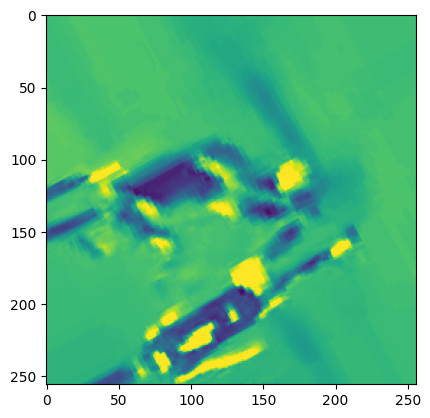

In [4]:
img, label = train_data.next()
print(img.shape)
plt.imshow(img[0])

In [5]:
print(train_data.class_indices)
print(val_data.class_indices)

{'Clean_Tackles': 0, 'Fouls': 1}
{'Clean_Tackles': 0, 'Fouls': 1}


In [6]:
clear_session()

In [7]:
# Creating model from scratch:
inputs=Input(shape=(256,256,1))
x = Conv2D(64,5,padding='same')(inputs)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Decreasing Filters and MAxPool Layers
x = Conv2D(32,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
# x = BatchNormalization()(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Dense Layers
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(1)(x)

#Output
out = Activation(activation='sigmoid')(x)

# final model:
model = Model(inputs,out,name='BaseModel')

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [8]:
# visualkeras.layered_view(model, legend=True, scale_xy=1.5, max_z=10,draw_volume=True)

In [9]:
%%capture
plot_model(model, show_shapes=True, show_layer_activations=True, dpi=64, to_file='model1.png')

In [10]:
# training model:
es=EarlyStopping(monitor='val_accuracy',patience=7,verbose=0,restore_best_weights=True)
logs=model.fit(train_data,validation_data=val_data,epochs=100,callbacks=[es])

Epoch 1/100
31/31 [==============================] - 75s 2s/step - loss: 0.6955 - accuracy: 0.4835 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 2/100
31/31 [==============================] - 78s 3s/step - loss: 0.6937 - accuracy: 0.4886 - val_loss: 0.6932 - val_accuracy: 0.5062
Epoch 3/100
31/31 [==============================] - 80s 3s/step - loss: 0.6939 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 4/100
31/31 [==============================] - 83s 3s/step - loss: 0.6939 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 5/100
31/31 [==============================] - 78s 3s/step - loss: 0.6944 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4938
Epoch 6/100
31/31 [==============================] - 80s 3s/step - loss: 0.6964 - accuracy: 0.4835 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 7/100
31/31 [==============================] - 83s 3s/step - loss: 0.6922 - accuracy: 0.5083 - val_loss: 0.6934 - val_accuracy: 0.4938
Epoch 8/100
3

In [11]:
clear_session()

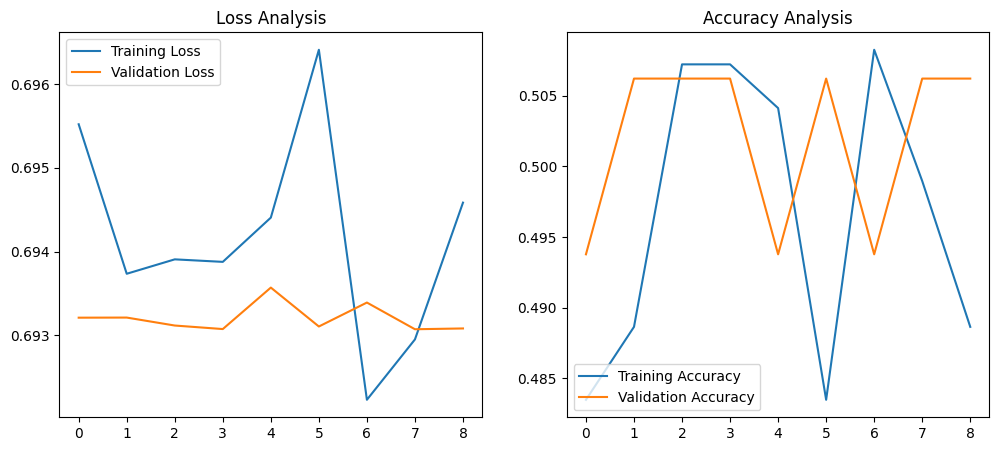

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(logs.history['loss'], label='Training Loss')
plt.plot(logs.history['val_loss'], label='Validation Loss')
plt.title('Loss Analysis')
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs.history['accuracy'], label='Training Accuracy')
plt.plot(logs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Analysis')
plt.legend()
plt.show()

In [13]:
model.evaluate(val_data)

8/8 [==============================] - 6s 735ms/step - loss: 0.6932 - accuracy: 0.5062


[0.6932100653648376, 0.5062240958213806]

In [14]:
model.save('/Users/HP/Documents/Projects/Virtual-Assistant-Referee--/weights.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Final validation accuracy: ~76%